# Setup

In [ ]:
%%capture
!pip3 install tclab

![](http://apmonitor.com/pdc/uploads/Main/tclab_front.jpg)

#### TCLab Library: https://github.com/jckantor/TCLab

# Imports

In [ ]:
import tclab
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
import random

![](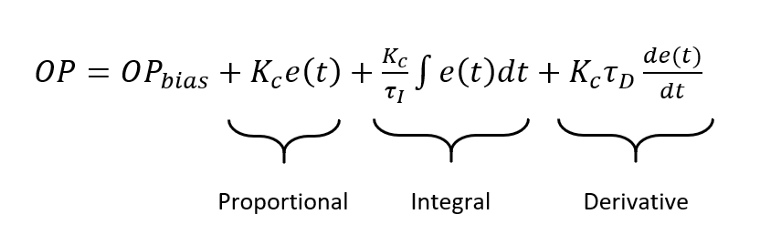)

# PID Controller

![]()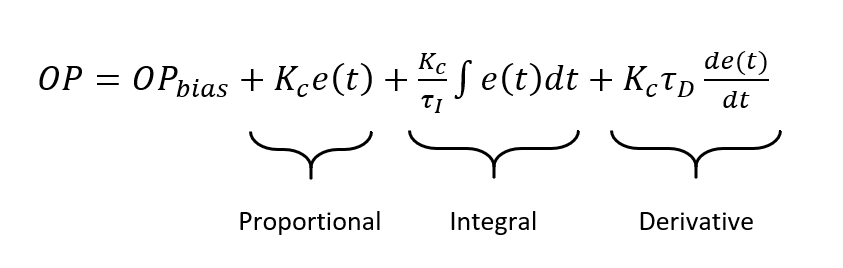

In [ ]:
# PID Parameters
Kc   = 6.0
tauI = 75.0 # sec
tauD = 0.0  # sec

#-----------------------------------------
# PID Controller
#-----------------------------------------
# inputs ---------------------------------
# sp = setpoint
# pv = current temperature
# pv_last = prior temperature
# ierr = integral error
# dt = time increment between measurements
# outputs --------------------------------
# op = output of the PID controller
# P = proportional
# I = integral
# D = derivative
def pid(sp,pv,pv_last,ierr,dt):
    # PID coefficients in terms of tuning parameters
    KP = Kc
    KI = Kc / tauI
    KD = Kc * tauD
    
    # ubias for controller (initial heater)
    op0 = 0 
    
    # upper and lower bounds on heater level
    ophi = 100
    oplo = 0
    
    # calculate the error
    error = sp - pv
    
    # calculate the integral error 
    # (add whatever the previous error was to the current time step)
    ierr = ierr + KI * error * dt
    
    # calculate the measurement derivative
    dpv = (pv - pv_last) / dt
    
    # calculate the PID output
    P = KP * error
    I = ierr
    D = -KD * dpv
    op = op0 + P + I + D
    
    # implement anti-reset windup
    # to account for heater limit between 0 and 100
    if op < oplo or op > ophi:
        I = I - KI * error * dt
        # clip output
        op = max(oplo,min(ophi,op))
        
    # return the controller output and PID terms
    return [op,P,I,D]

# Setup run parameters

TCLab version 0.4.9
Simulated TCLab
TCLab Model disconnected successfully.


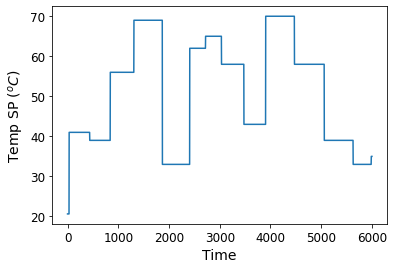

In [ ]:
##### Set up run parameters #####

# Run time in minutes
run_time = 100.0

# Number of cycles
loops = int(60.0*run_time)

# arrays for storing data
T1 = np.zeros(loops) # measured T (degC)
Q1 = np.zeros(loops) # Heater values
tm = np.zeros(loops) # Time

# Temperature set point (degC)
with tclab.TCLabModel() as lab:
    Tsp1 = np.ones(loops) * lab.T1 # temperature of sensor 1
    
# vary temperature setpoint
end = 30 # leave 1st 30 seconds of temp set point as room temp
while end <= loops:
    start = end
    # keep new temp set point value for anywhere from 4 to 10 min
    end += random.randint(240,600) 
    Tsp1[start:end] = random.randint(30,70)

# Plot
plt.plot(Tsp1)
plt.xlabel('Time',size=14)
plt.ylabel(r'Temp SP ($^oC$)',size=14)
plt.xticks(size=12)
plt.yticks(size=12)
plt.savefig('SP_profile.png');

# Generate data

In [ ]:
# Run test
with tclab.TCLabModel() as lab:
    # Find current T1, T2
    print('Temperature 1: {0:0.2f} °C'.format(lab.T1))
    print('Temperature 2: {0:0.2f} °C'.format(lab.T2))

    # Integral error
    ierr = 0.0
    # Integral absolute error
    iae = 0.0

    start_time = time.time()
    prev_time = start_time

    for i in range(loops):
        # Delay 1 second
        if time.time() > prev_time + 1.0:
            print('Exceeded cycle time by ',time.time()-prev_time-1.0)
        else:
            while time.time() < prev_time + 1.0:
                pass
        
        # Record time and change in time
        t = time.time()
        dt = t - prev_time
        prev_time = t
        tm[i] = t - start_time

        # Read temperatures in Kelvin 
        T1[i] = lab.T1

        # Integral absolute error
        # set_point - process_variable
        iae += np.abs(Tsp1[i]-T1[i])

        # Calculate PID output
        [Q1[i],P,ierr,D] = pid(Tsp1[i],T1[i],T1[i-1],ierr,dt)

        # Write heater output (0-100)
        lab.Q1(Q1[i])

        # Print line of data
        print(('{:6.1f} {:6.2f} {:6.2f} ' + \
              '{:6.2f} {:6.2f} {:6.2f} {:6.2f} {:6.2f}').format( \
                  tm[i],Tsp1[i],T1[i], \
                  Q1[i],P,ierr,D,iae))     

Streaming output truncated to the last 5000 lines.
1001.0  68.00  67.68  79.23   1.90  77.33  -0.00 3348.89
1002.0  68.00  67.68  79.25   1.90  77.35  -0.00 3349.20
1003.0  68.00  67.68  79.28   1.90  77.38  -0.00 3349.52
1004.0  68.00  67.68  79.30   1.90  77.40  -0.00 3349.84
1005.0  68.00  67.68  79.33   1.90  77.43  -0.00 3350.15
1006.0  68.00  67.68  79.36   1.90  77.45  -0.00 3350.47
1007.0  68.00  67.68  79.38   1.90  77.48  -0.00 3350.79
1008.0  68.00  67.68  79.41   1.90  77.50  -0.00 3351.11
1009.0  68.00  67.68  79.43   1.90  77.53  -0.00 3351.42
1010.0  68.00  67.68  79.46   1.90  77.56  -0.00 3351.74
1011.0  68.00  67.68  79.48   1.90  77.58  -0.00 3352.06
1012.0  68.00  67.68  79.51   1.90  77.61  -0.00 3352.37
1013.0  68.00  67.68  79.53   1.90  77.63  -0.00 3352.69
1014.0  68.00  67.68  79.56   1.90  77.66  -0.00 3353.01
1015.0  68.00  67.68  79.58   1.90  77.68  -0.00 3353.32
1016.0  68.00  67.68  79.61   1.90  77.71  -0.00 3353.64
1017.0  68.00  67.68  79.63   1.90  7

# Save data to `csv`

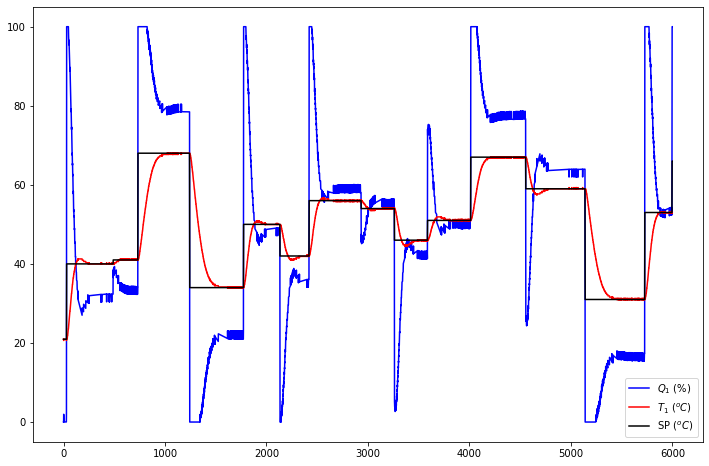

In [ ]:
csv_filename = f"PID_train_data_{int(run_time)}_mins.csv"
plot_filename = f"PID_train_{int(run_time)}_mins.png"
# Save csv file
data = pd.DataFrame()
data['Q1'] = Q1 # heater output
data['T1'] = T1 # temperature output by PID
data['Tsp'] = Tsp1 # set point
data.to_csv(csv_filename,index=False)

# Plot
plt.figure(figsize=(12,8))
plt.plot(data['Q1'],'b-',label='$Q_1$ (%)')
plt.plot(data['T1'],'r-',label='$T_1$ $(^oC)$')
plt.plot(data['Tsp'],'k-',label='SP $(^oC)$')
plt.legend()
plt.savefig(plot_filename);

In [ ]:
# saving files
!cp {csv_filename} /content/drive/MyDrive/Projects/Emulating_PID_controller_DL/output
!cp {plot_filename} /content/drive/MyDrive/Projects/Emulating_PID_controller_DL/output